# Integrated Project 2
In this project we prepare a prototype of a machine learning model for Zyfra. The company develops efficiency solutions for heavy industry.
The model should predict the amount of gold recovered from gold ore. We have the data on extraction and purification.
The model will help to optimize the production and eliminate unprofitable parameters.

## Data Preparation
### Datasets
Loading data files and viewing info.

In [28]:
import pandas as pd
import numpy as np
from sklearn.utils import shuffle
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

In [2]:
try:
    df_train = pd.read_csv('gold_recovery_train.csv')
    df_test = pd.read_csv('gold_recovery_test.csv')
    df_full = pd.read_csv('gold_recovery_full.csv')
except:
    df_train = pd.read_csv('/datasets/gold_recovery_train.csv')
    df_test = pd.read_csv('/datasets/gold_recovery_test.csv')
    df_full = pd.read_csv('/datasets/gold_recovery_full.csv')

In [3]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16860 entries, 0 to 16859
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                16860 non-null  object 
 1   final.output.concentrate_ag                         16788 non-null  float64
 2   final.output.concentrate_pb                         16788 non-null  float64
 3   final.output.concentrate_sol                        16490 non-null  float64
 4   final.output.concentrate_au                         16789 non-null  float64
 5   final.output.recovery                               15339 non-null  float64
 6   final.output.tail_ag                                16794 non-null  float64
 7   final.output.tail_pb                                16677 non-null  float64
 8   final.output.tail_sol                               16715 non-null  float64


In [4]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5856 entries, 0 to 5855
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        5856 non-null   object 
 1   primary_cleaner.input.sulfate               5554 non-null   float64
 2   primary_cleaner.input.depressant            5572 non-null   float64
 3   primary_cleaner.input.feed_size             5856 non-null   float64
 4   primary_cleaner.input.xanthate              5690 non-null   float64
 5   primary_cleaner.state.floatbank8_a_air      5840 non-null   float64
 6   primary_cleaner.state.floatbank8_a_level    5840 non-null   float64
 7   primary_cleaner.state.floatbank8_b_air      5840 non-null   float64
 8   primary_cleaner.state.floatbank8_b_level    5840 non-null   float64
 9   primary_cleaner.state.floatbank8_c_air      5840 non-null   float64
 10  primary_clea

In [5]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22716 entries, 0 to 22715
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                22716 non-null  object 
 1   final.output.concentrate_ag                         22627 non-null  float64
 2   final.output.concentrate_pb                         22629 non-null  float64
 3   final.output.concentrate_sol                        22331 non-null  float64
 4   final.output.concentrate_au                         22630 non-null  float64
 5   final.output.recovery                               20753 non-null  float64
 6   final.output.tail_ag                                22633 non-null  float64
 7   final.output.tail_pb                                22516 non-null  float64
 8   final.output.tail_sol                               22445 non-null  float64


There are plenty of missing values.

### Recovery
Calculating recovery for the rougher concentrate.

In [6]:
def recovery(concentrate: float, feed: float, tail: float) -> float:
    return (concentrate * (feed - tail)) / (feed * (concentrate - tail)) * 100

In [7]:
my_recovery = recovery(
    df_train['rougher.output.concentrate_au'].fillna(method='pad'),
    df_train['rougher.input.feed_au'].fillna(method='pad'),
    df_train['rougher.output.tail_au'].fillna(method='pad'),
)

Finding the mean absolute error between my calculated recovery and the one in the dataset.

In [8]:
mean_absolute_error(my_recovery[df_train['rougher.output.recovery'].notnull()], df_train['rougher.output.recovery'].dropna())

9.303415616264301e-15

This is practically zero error. The recovery was calculated correctly when it was calculated, but maybe there are missing values that can be calculated.

In [9]:
my_recovery.count() - df_train['rougher.output.recovery'].count()

1404

There are 290 values that can fill the blanks in the dataset.

In [10]:
df_train['rougher.output.recovery'] = df_train['rougher.output.recovery'].fillna(my_recovery)

### Features
The following features are not in the test dataset.

In [11]:
df_train.columns.difference(df_test.columns).tolist()

['final.output.concentrate_ag',
 'final.output.concentrate_au',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_au',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_au',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'rougher.calculation.au_pb_ratio',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_au',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_au',
 'rougher.output.ta

The test data excludes the concentrations in all stages except in the unprocessed ore. It makes perfect sense, because we don't know these numbers at the start of the process, and including them in model training will be a target leak.

### Preprocessing
Training data is split into features and target, then shuffled. Shuffling is done to avoid training the model on similiar data consecutively, which makes fitting less effective. Missing values are filled with the last valid value because parameters that are next to each other in terms of time are often similar.

In [12]:
x = df_train.fillna(method='pad')[df_test.columns].drop('date', axis=1)
y = df_train.fillna(method='pad')[['rougher.output.recovery', 'final.output.recovery']]

x, y = shuffle(x, y, random_state=420)

x = x.reset_index(drop=True)
y = y.reset_index(drop=True)

Extracion of test features and target from the full data.

In [13]:
y_test = df_full[np.isin(df_full['date'], df_test['date'])][['rougher.output.recovery', 'final.output.recovery']]
x_test = df_full[np.isin(df_full['date'], df_test['date'])][df_test.columns].drop('date', axis=1)

## Data Analysis
### Metal Concentrations

In [14]:
for metal in ['au', 'ag', 'pb']:
    print(df_train[['rougher.input.feed_'+metal, 'rougher.output.concentrate_'+metal, 
                    'primary_cleaner.output.concentrate_'+metal, 'final.output.concentrate_'+metal]].mean())

rougher.input.feed_au                     7.170717
rougher.output.concentrate_au            17.401541
primary_cleaner.output.concentrate_au    29.164596
final.output.concentrate_au              39.467217
dtype: float64
rougher.input.feed_ag                     7.832347
rougher.output.concentrate_ag            10.580475
primary_cleaner.output.concentrate_ag     7.422640
final.output.concentrate_ag               4.716907
dtype: float64
rougher.input.feed_pb                    3.218931
rougher.output.concentrate_pb            6.880322
primary_cleaner.output.concentrate_pb    8.620294
final.output.concentrate_pb              9.113559
dtype: float64


Gold concentration goes up dramatically with each step, which is the whole point of the process, reaching 5.5 times the original ore concentration on average. Silver concentration only rises in floatation, then decrease in the following steps. Lead concentrations rise each step, but much more mildly than gold, reaching under 3 times the original ore concentration on average.

### Particle Size

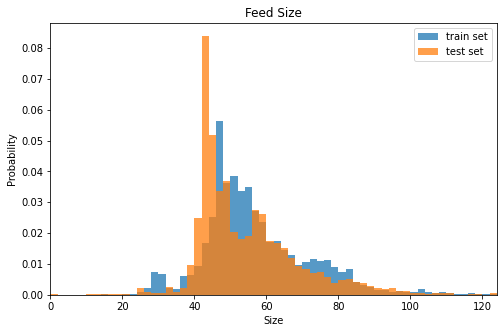

In [15]:
plt.figure(figsize=(8, 5))
bins = list(range(0, 126, 2))
plt.hist(df_train['rougher.input.feed_size'], label='train set', bins=bins, alpha=0.75, density=True)
plt.hist(df_test['rougher.input.feed_size'], label='test set', bins=bins, alpha=0.75, density=True)
plt.legend()
plt.title('Feed Size')
plt.xlabel('Size')
plt.ylabel('Probability')
plt.xlim(bins[0], bins[-1])
plt.show()

Particle size distributions in training and testing data do not vary significantly.

### Anomalies

In [16]:
c_total = pd.DataFrame({
    'raw_feed': df_train[['rougher.input.feed_ag', 'rougher.input.feed_au', 
                     'rougher.input.feed_pb', 'rougher.input.feed_sol']].sum(axis=1),
    'rougher_concentrate': df_train[['rougher.output.concentrate_ag', 'rougher.output.concentrate_au', 
                                     'rougher.output.concentrate_pb', 'rougher.output.concentrate_sol']].sum(axis=1),
    'final_concentrate': df_train[['final.output.concentrate_ag', 'final.output.concentrate_au', 
                                   'final.output.concentrate_pb', 'final.output.concentrate_sol']].sum(axis=1)
})


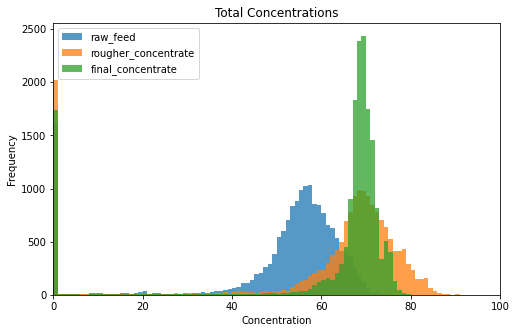

In [17]:
plt.figure(figsize=(8, 5))
bins = list(range(0, 101, 1))
for col in c_total.columns:
    plt.hist(c_total[col], label=col, alpha=0.75, bins=bins)
plt.legend()
plt.xlim(bins[0], bins[-1])
plt.xlabel('Concentration')
plt.ylabel('Frequency')
plt.title('Total Concentrations')
plt.show()

There are anomalous low (<1) values in the total concentrations. We'll repeat the data preprocessing to remove this data.

In [18]:
idx = (c_total['raw_feed'] > 1) & (c_total['rougher_concentrate'] > 1) & (c_total['final_concentrate'] > 1) 

df_train_final = df_train.fillna(method='pad')[idx]

x = df_train_final[df_test.columns].drop('date', axis=1)
y = df_train_final[['rougher.output.recovery', 'final.output.recovery']]

x, y = shuffle(x, y, random_state=420)

x = x.reset_index(drop=True)
y = y.reset_index(drop=True)

In [19]:
1 - x.shape[0] / df_train.shape[0]

0.1344009489916963

Anomalies accounted for 13.5% of the training data.

## Model
### Scoring Method
For scoring, we'll use symmetric Mean Absolute Percentage Error (sMAPE). The final score will be composed of 25% rougher concentrate recovery sMAPE and 75% final concentrate recovery sMAPE.

In [20]:
def smape(targ: pd.Series, pred: pd.Series) -> float:
    return ((targ - pred).abs() / (targ.abs() + pred.abs()) * 2).mean() * 100

def fsmape(targ: pd.DataFrame, pred: pd.DataFrame, 
           rough='rougher.output.recovery', 
           final='final.output.recovery', 
           ratio=0.25) -> float:
    rough_targ = targ[rough]
    final_targ = targ[final]
    rough_pred = pred[rough]
    final_pred = pred[final]
    
    return ratio*smape(rough_targ, rough_pred) + (1-ratio)*smape(final_targ, final_pred)

### Model Evaluation
We'll use the cross validation method.

In [21]:
def cross_val(model, x: pd.DataFrame, y: pd.DataFrame, n: int=3) -> float:
    sample_size = int(x.shape[0]/n)
    scores = []
    for i in range(0, sample_size*n, sample_size):
        valid_indexes = list(range(i, i+sample_size))
        train_indexes = [*list(range(0, i)), *list(range(i+sample_size, x.shape[0]))]
        
        features_train = x.iloc[train_indexes]
        features_valid = x.iloc[valid_indexes]
        target_train = y.iloc[train_indexes]
        target_valid = y.iloc[valid_indexes]

        model.fit(features_train, target_train)
        pred = pd.DataFrame(model.predict(features_valid), columns=y.columns, index=target_valid.index)
        score = fsmape(target_valid, pred)

        scores.append(score)

    return pd.Series(scores).mean()

First we'll create and score a dummy model, that always predicts the average of the training targets, as a baseline for comparison.

In [30]:
dummy_model = DummyRegressor()
dummy_model.fit(x, y)
dummy_pred = pd.DataFrame(dummy_model.predict(x_test.fillna(method='pad')), columns=y.columns, index=y_test.index)
baseline_score = fsmape(y_test, dummy_pred)
baseline_score

12.523269743391708

Now we'll try a linear regression model. The cross validation score:

In [33]:
l_model = LinearRegression()
cross_val(l_model, x, y)

23.1991153910034

And test score:

In [34]:
l_model.fit(x, y)
l_pred = pd.DataFrame(l_model.predict(x_test.fillna(method='pad')), columns=y.columns, index=y_test.index)
fsmape(y_test, l_pred)

26.396052809705033

It performed much worse than the simple model. 

Next we'll try a random forest. We pick the optimal hyperparameters by looping through a range of values.

In [35]:
best = dict(n_estimators=0, max_depth=0, score=100)

for trees in range(500, 1001, 250):
    for depth in range(50, 101, 25):
        model = RandomForestRegressor(random_state=420, n_estimators=trees, max_depth=depth, n_jobs=-1)
        score = cross_val(model, x, y)
        print(f'{trees} estimators, {depth} deep sMAPE: {score}')
        if score < best['score']:
            best['n_estimators'] = trees
            best['max_depth'] = depth
            best['score'] = score
            print('^ best so far')
print('done.')

500 estimators, 50 deep sMAPE: 5.8477994900352295
^ best so far
500 estimators, 75 deep sMAPE: 5.847643858173302
^ best so far
500 estimators, 100 deep sMAPE: 5.847643858173302
750 estimators, 50 deep sMAPE: 5.843089703806082
^ best so far
750 estimators, 75 deep sMAPE: 5.843044099788632
^ best so far
750 estimators, 100 deep sMAPE: 5.843044099788632
1000 estimators, 50 deep sMAPE: 5.840393911567812
^ best so far
1000 estimators, 75 deep sMAPE: 5.840339008199403
^ best so far
1000 estimators, 100 deep sMAPE: 5.840339008199403
done.


Fitting the optimized model to all train data.

In [36]:
best_model = RandomForestRegressor(random_state=420, n_estimators=best['n_estimators'], max_depth=best['max_depth'], n_jobs=-1)
# best_model = RandomForestRegressor(max_depth=75, n_estimators=1000, n_jobs=-1, random_state=420)
best_model.fit(x, y)

RandomForestRegressor(max_depth=75, n_estimators=1000, n_jobs=-1,
                      random_state=420)

Final test.

In [38]:
pred = pd.DataFrame(model.predict(x_test.fillna(method='pad')), columns=y.columns, index=y_test.index)
forest_score = fsmape(y_test, pred)
print('Test sMAPE:', forest_score)

Test sMAPE: 11.714215048680021


Rate of improvement.

In [40]:
forest_score / baseline_score -1

-0.06460410989219567

The final model's error is 6.5% lower than the dummy model's.